# Proyecto Final

### <font color=blue><font color=red> Nota: Los análisis para realizar el Feature Engeneering, gráficas y tablas se quitaron, con el objetivo de dejar en una función la limpieza de datos y hacer más corto el proyecto, al final se adjuntan las imágenes de comprobación que se realizaron estos pasos.

### Carga de librerías a utilizar y data

In [3]:
import numpy as np
import pandas as pd
import math as mt
from matplotlib import pyplot as plt
import tensorflow as tf
from scipy.stats import norm
from numpy import random
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
import joblib as jl
from datetime import datetime
import csv
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import recall_score


In [4]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Variables que no son relevantes para el análisis:
* PassengerID
* Name --Realizaremos análisis en esta para ver si afecta---

In [5]:
def data_split(data):    
    
    x = data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
    y = data.iloc[:,[11]]
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.20, random_state=42, shuffle = True)
    
    X_train, X_val, Y_train, Y_val =  train_test_split(X_train,Y_train,test_size=0.20, random_state=42, shuffle = True)
    return(X_train, X_test, Y_train, Y_test, X_val, Y_val)

In [6]:
def data_cleaning(data_w): #Recibe la data X_train
    #Eliminando Variables que no sirven en prediccion
    data_w = data_w.drop(["PassengerId", "Cabin", "Ticket", "Name","SibSp", "Parch" ], axis=1)
    
    #Modificando variable Age, nueva variable agerand
    data_w["AgeRand"] = data_w["Age"]
    null_rows = data_w['AgeRand'].isnull()
    num_null_rows = sum(null_rows)
    rand = random.randint(1, 65, size=num_null_rows)
    data_w.loc[null_rows, 'AgeRand'] = rand
    
    #Trabajando con Outliers:
    data_w["AgeRand"] = np.where(data_w["AgeRand"] < 9, 14,data_w["AgeRand"])
    data_w["AgeRand"] = np.where(data_w["AgeRand"] > 60, 60,data_w["AgeRand"])
    
    #Trabajando con variables continuas:
    DUM_pass_class = pd.get_dummies(data_w["passenger_class"], prefix='passenger_class')
    DUM_pass_sex = pd.get_dummies(data_w["passenger_sex"], prefix='passenger_sex')
    DUM_pass_embarked = pd.get_dummies(data_w["Embarked"], prefix='Embarked')
    data_w = pd.concat([data_w,DUM_pass_class,DUM_pass_sex, DUM_pass_embarked], axis=1)
    
    data_w = data_w.drop(["passenger_class","passenger_sex", "Embarked", "Age"], axis=1)
    data_w['Age_sqrt'] = data_w['AgeRand'].apply(np.sqrt)
    data_w['Fare_Sqrt'] = data_w['Fare'].apply(np.sqrt)
    
    data_w = data_w.drop(["AgeRand", "Fare"], axis=1)
    
    #Feature Scaling
    scaler = MinMaxScaler()
    for column in data_w.columns:
        nombre = "scl_" + column
      #  print(nombre)
        data_w[nombre]= (data_w[column] - data_w[column].mean()) / data_w[column].std() 
    
    
    data_w = data_w.drop(["passenger_class_Lower", "passenger_class_Middle","passenger_class_Upper",
                       "passenger_sex_F","passenger_sex_M","Embarked_C","Embarked_Q","Embarked_S", "Age_sqrt",
                       "Fare_Sqrt"], axis=1)
    
    #print("Estas son las variables que quedan", data_w.info())
    return(data_w)

In [7]:
import csv
def Write_Log(file_name, writer, encoding="utf-8"):
    with open(file_name, mode = "a+", newline='\n' ) as write_obj:
        csv_writer = csv.writer(write_obj, delimiter=",", quotechar='"',quoting=csv.QUOTE_NONE)
        csv_writer.writerow(writer)

## Trabajando con los modelos:

### Tree:

In [45]:
def tree_entrenamiento(data_w, Y_train, depth):
    
    #data_w = data_cleaning(data_w)
    #Arbol de decisión
    clfTREE = tree.DecisionTreeClassifier(criterion="entropy", splitter = 'best', max_depth=depth)
    clfTREE = clfTREE.fit(data_w, Y_train.values.ravel())
    YT_pred = clfTREE.predict(data_w)    
    
        #Precision del modelo
    accuracy = "{:0.2f}".format(metrics.accuracy_score(Y_train, YT_pred))
    recall = "{:0.2f}".format(metrics.recall_score(Y_train, YT_pred, pos_label='Y'))
    f1 = "{:0.2f}".format(metrics.f1_score(Y_train, YT_pred,pos_label='Y'))
    precision = "{:0.2f}".format(metrics.precision_score(Y_train, YT_pred,pos_label='Y'))
    
    print("Tree Accuracy:", accuracy )
    print("Tree Recall:", recall )
    print("Tree F1:", f1 )
    print("Tree precision:", precision )
    print("")
    
    dep = str(depth)
    writer ="Tree_Depth="+ dep + "_Variables=" + str(data_w.columns.values).replace('\n', '').replace('\r', '') +"_ACC="+accuracy+"_REC="+recall+"_F1="+f1+"_PR="+precision
   
    Write_Log("CadenaConfiguracion.csv",[writer])
    
    #Código que escríbira en el PKL
    writer_pkl = "TREE_Dep=" + dep + "_ACC="+str(accuracy)+"_REC="+str(recall)+"_F1="+str(f1)+"_PR="+str(precision) +".pkl"
    #print(writer_pkl)
    jl.dump(clfTREE, writer_pkl,compress=0, protocol=None)
    
    
    return (YT_pred)

## SVC:

In [46]:
def SVC_entrenamiento(data_w, Y_train, c_val, degree_val):    
    #data_w = data_cleaning(data_w)
    clfSVM = svm.SVC(kernel='poly',C=c_val, gamma = 'auto', degree = degree_val) 
    clfSVM = clfSVM.fit(data_w, Y_train.values.ravel())
    YS_pred = clfSVM.predict(data_w)
    
    #Precision del modelo
    accuracy = "{:0.2f}".format(metrics.accuracy_score(Y_train, YS_pred))
    recall = "{:0.2f}".format(metrics.recall_score(Y_train, YS_pred, pos_label='Y'))
    f1 = "{:0.2f}".format(metrics.f1_score(Y_train, YS_pred,pos_label='Y'))
    precision = "{:0.2f}".format(metrics.precision_score(Y_train, YS_pred,pos_label='Y'))
    
    print("SVM Accuracy:", accuracy )
    print("SVM Recall:", recall )
    print("SVM F1:", f1 )
    print("SVM precision:", precision )
    print("")
    
    cval=str(c_val)
    degre=str(degree_val)
    writer ="SVM_RegParam="+ cval +"_Degree="+ degre + "_Variables=" + str(data_w.columns.values).replace('\n', '').replace('\r', '')+"_ACC="+accuracy+"_REC="+recall+"_F1="+f1+"_PR="+precision
    Write_Log("CadenaConfiguracion.csv",[writer])
    writer_pkl = "SVM_DG=" + degre + "_ACC="+accuracy+"_REC="+recall+"_F1="+f1+"_PR="+precision +".pkl"
   
    jl.dump(clfSVM, writer_pkl,compress=0, protocol=None)
    return (YS_pred)
    


## Naive:

In [47]:
class naive_training():      

        
    def naive_entrenamiento(data_w,Y):

        #data_w = data_cleaning(data_w)
        samples, features = data_w.shape
        y_class = np.unique(Y)
        n_class = len(y_class)

        mean = np.array(data_w.groupby(by=Y).mean())
        var = np.array(data_w.groupby(by=Y).var())
        priors = np.array(data_w.groupby(by=Y).count()/samples)

        pred = naive_training.Naive_Predict(data_w, mean,var,priors,y_class)

        accuracy = "{:0.2f}".format(metrics.accuracy_score(Y, pred))
        precision = "{:0.2f}".format(metrics.precision_score(Y, pred,pos_label='Y'))
        recall = "{:0.2f}".format(metrics.recall_score(Y, pred,pos_label='Y'))
        f1 = "{:0.2f}".format(metrics.f1_score(Y, pred,pos_label='Y'))

        writer = "Naive_"+"Vars="+ str(data_w.columns.values).replace('\n', '').replace('\r', '')+"_A="+accuracy+"_R="+recall+"_F1="+f1+"_P="+precision
        Write_Log("CadenaConfiguracion.csv",[writer])

        print("Navie_Accuracy:",accuracy)
        print("Navie_Recall:",recall)
        print("Navie_F1:",f1)
        print("Navie_Precision:",precision)
        print("")
        #str(data_w.columns.values) 
        writer_pkl = "Naive1=" + "ACC=" + accuracy + "PRE=" + precision +".pkl"
   
        jl.dump([mean, var, priors,y_class], writer_pkl,compress=0, protocol=None)
    
        return (pred)
    
    
    def Naive_Predict(X, m,v,p,y_class):
        #X = data_cleaning(data_w)
        Y_Pred = []
        for x in np.array(X):
            posteriors = []
            for idx, c in enumerate(y_class):
                prior = np.log(p[idx][0])

                numer = np.exp(-((x - m[idx])**2)/(2 * v[idx]) )
                denomi = np.sqrt(2 * np.pi * v[idx])
                numl =np.log(numer/denomi)

                post = np.sum(numl)
                post = prior + post

                posteriors.append(post)

            Y_Pred.append(y_class[np.argmax(posteriors)])
        return np.array(Y_Pred)
    

## Regresión Logistica:

In [9]:
def logistic_regresion(data_w, Y_train, alpha, epochs):
    x_orig = data_w.iloc[:,:].values
    y_orig = Y_train.iloc[:,:].values
    oneHot = OneHotEncoder()

    oneHot.fit(x_orig)
    x = oneHot.transform(x_orig).toarray()
    oneHot.fit(y_orig)
    y = oneHot.transform(y_orig).toarray()
    m, n = x.shape

    X = tf.placeholder(tf.float32, [None, n])

    Y = tf.placeholder(tf.float32, [None, 2])

    W = tf.Variable(tf.zeros([n, 2]))

    # Variable Bias entrenable
    b = tf.Variable(tf.zeros([2]))
    # Hypothesis
    Y_hat = tf.nn.sigmoid(tf.add(tf.matmul(X, W), b))

    # sigmoid y cost function
    cost = tf.nn.sigmoid_cross_entropy_with_logits(
                        logits = Y_hat, labels = Y)

    # gradient descent
    optimizer = tf.train.GradientDescentOptimizer(
             learning_rate = alpha).minimize(cost)

    # Global Variables Initializer
    init = tf.global_variables_initializer()

 
    with tf.Session() as sess:
        sess.run(init)
        cost_history, accuracy_history = [], []

        for epoch in range(epochs):
            cost_per_epoch = 0

            sess.run(optimizer, feed_dict = {X : x, Y : y})
            c = sess.run(cost, feed_dict = {X : x, Y : y})
            correct_prediction = tf.equal(tf.argmax(Y_hat, 1),
                                              tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction,
                                                     tf.float32))

            # Storing Cost and Accuracy to the history
            cost_history.append(sum(sum(c)))
            accuracy_history.append(accuracy.eval({X : x, Y : y}) * 100)


        Weight = sess.run(W) 
        Bias = sess.run(b)   

        # Final Accuracy
        correct_prediction = tf.equal(tf.argmax(Y_hat, 1),
                                          tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                                 tf.float32))
        print("LR_Accuracy:", accuracy_history[-1], "%")
        
        #Escritura al excel
        alfa = str(alpha)
        epoches = str(epochs)
        accura = str(accuracy_history[-1])
        writer ="LogReg_LR="+ alfa +"_epochs="+ epoches + "_Variables=" + str(data_w.columns.values).replace('\n', '').replace('\r', '') + "ACC" + accura
        
        Write_Log("CadenaConfiguracion.csv",[writer])
        
        
            #Código que escríbira en el PKL
    #writer_pkl = "LR_Alp=" + alfa + "epoch="+epoches+ "_ACC"+ accura + ".pkl"
    #jl.dump(optimizer, writer_pkl,compress=0, protocol=None)
       

### Se agrega la siguiente regresión Logistica ya que no pude exportar e importar la enterior, lo que afecta las decisiones finales de mi modelo.

In [50]:
from sklearn.linear_model import LogisticRegression as LR
def logistic_regresion_V2(X, Y, alpha, epochs):
    clfREG = LR(C=alpha, solver='liblinear',random_state=epochs)
    clfREG = clfREG.fit(X, Y.values.ravel())
    YS_pred = clfREG.predict(X)

    #Precision del modelo
    accuracy = "{:0.2f}".format(metrics.accuracy_score(Y, YS_pred))
    recall = "{:0.2f}".format(metrics.recall_score(Y, YS_pred, pos_label='Y'))
    f1 = "{:0.2f}".format(metrics.f1_score(Y, YS_pred,pos_label='Y'))
    precision = "{:0.2f}".format(metrics.precision_score(Y, YS_pred,pos_label='Y'))
    
    print("LR_Accuracy:",accuracy)
    print("LR_Recall:",recall)
    print("LR_F1:",f1)
    print("LR_Precision:",precision)
    print("")

    
    alpha=str(alpha)
    epochs=str(epochs)
    writer ="LRV213="+ alpha +"_epochs="+ epochs + "_Variables=" + str(X.columns.values).replace('\n', '').replace('\r', '')+"_ACC="+accuracy+"_REC="+recall+"_F1="+f1+"_PR="+precision
    Write_Log("CadenaConfiguracion.csv",[writer])
    writer_pkl = "Log_V22=" + alpha + "_ACC="+accuracy+"_REC="+recall+"_F1="+f1+"_PR="+precision +".pkl"
   
    jl.dump(clfREG, writer_pkl,compress=0, protocol=None)
    
    return (YS_pred)

## Carga, limpieza y división de data:

In [10]:
data = pd.read_csv('data_titanic_proyecto.csv')

X_train, X_test, Y_train, Y_test, X_val, Y_val = data_split(data)

X_train = data_cleaning(X_train)
X_test = data_cleaning(X_test)
X_val = data_cleaning(X_val)


In [51]:
Pred_T  = tree_entrenamiento(X_train, Y_train, 20) #El último número es la profundidad del arbol

Pred_S  = SVC_entrenamiento(X_train, Y_train, 20, 3) #Penúltimo parámetro de regularización, último el degree

Pred_N = naive_training.naive_entrenamiento(X_train,Y_train.passenger_survived)

logistic_regresion(X_train, Y_train, 0.0025, 300) #Penúltimo parámetro lr, último Epochs

Pred_R = logistic_regresion_V2(X_train, Y_train, 0.0025, 300)

Tree Accuracy: 0.98
Tree Recall: 0.95
Tree F1: 0.97
Tree precision: 0.99

SVM Accuracy: 0.82
SVM Recall: 0.64
SVM F1: 0.73
SVM precision: 0.85

Navie_Accuracy: 0.77
Navie_Recall: 0.74
Navie_F1: 0.70
Navie_Precision: 0.68

LR_Accuracy: 81.3708245754242 %
LR_Accuracy: 0.78
LR_Recall: 0.72
LR_F1: 0.71
LR_Precision: 0.69



# Comparacion de Modelos

In [59]:
Cuadre_final = pd.DataFrame({'Tree': Pred_T,
                      'SVM': Pred_S,
                      'Naive': Pred_N,
                      'Log_Regression': Pred_T
                     })


Data_Moda = Cuadre_final.mode(axis=1)
Y_hat = pd.DataFrame({'Y_Moda': Data_Moda[0]})


Y_C = Y_train.copy()
Cuadre_final.reset_index(drop=True, inplace=True)
Y_C.reset_index(drop=True, inplace=True)
val_mod = pd.concat( [Cuadre_final, Y_C.passenger_survived,Y_hat], axis=1)
#val_mod

Cuadre_Info = pd.DataFrame({'Precision': ["{:0.2f}".format(metrics.precision_score(Y_train, Y_hat,pos_label='Y'))],
                           'Recall': ["{:0.2f}".format(metrics.recall_score(Y_train, Y_hat,pos_label='Y'))],
                           'F1': ["{:0.2f}".format(metrics.f1_score(Y_train, Y_hat,pos_label='Y'))],
                           'Accuracy': ["{:0.2f}".format(metrics.accuracy_score(Y_train, Y_hat))]
                     })
Cuadre_Info

,Precision,Recall,F1,Accuracy
0,0.99,0.76,0.86,0.91


## Validacion cruzada con k-fold cross validation 

#### Como se puede aplicar al proyecto:

Esta se puede aplicar al proyecto para una validacion como una validacion extra de nuestros modelos solo con porciones de la data con la cual estamos entrenando o testeando, es importante ya que gracias a este podemos detectar a tiempo un overfitting de nuesto modelo o un underfitting y trabajar en ello para poder corregirlo.

Este se intentó poner en practica en el proyecto, por cuestiones laborales no me dio tiempo de terminar esta implementación:

## Intento: Validacion cruzada con K-fold Cross Validation

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    Pred_T  = tree_entrenamiento(X_train, Y_train, 20)
    Pred_S  = SVC_entrenamiento(X_train, Y_train, 20, 3)
    Pred_N = naive_training.naive_entrenamiento(X_train,Y_train.passenger_survived)

    log = cross_validate(Pred_T, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(Pred_S, X, y, cv=folds, scoring=scoring)
    #nai = cross_validate(Pred_N, X, y, cv=folds, scoring=scoring)
    #rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    #gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    print(log)
    
    models_scores_table = pd.DataFrame({'Decision Tree':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()]},
                                       
                                      #'Decision Tree':[dtr['test_accuracy'].mean(),
                                      #                 dtr['test_precision'].mean(),
                                      #                 dtr['test_recall'].mean(),
                                      #                 dtr['test_f1_score'].mean()],
                                       
                                      #'Random Forest':[rfc['test_accuracy'].mean(),
                                      #                 rfc['test_precision'].mean(),
                                      #                 rfc['test_recall'].mean(),
                                      #                 rfc['test_f1_score'].mean()],
                                       
                                      #'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                      #                        gnb['test_precision'].mean(),
                                      #                        gnb['test_recall'].mean(),
                                      #                        gnb['test_f1_score'].mean()]},
                                      #'''
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [ ]:
models_evaluation(X_train, Y_train, 2)

### <font color=red> Comprobación de gráficas utilizadas para la limpieza de datos:

## Eliminado NA's de la variable Age, revisando que funcion nos resulta mejor para no afectar el modelo:
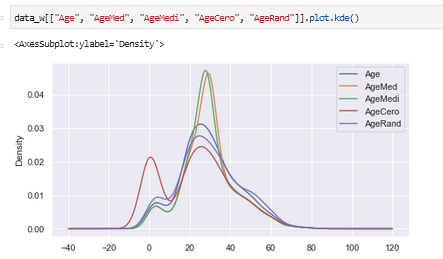

## Modificando Outliers en data:

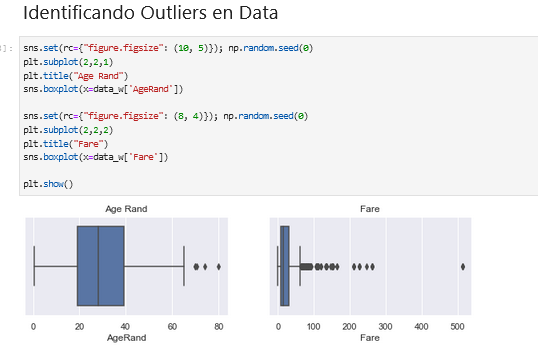

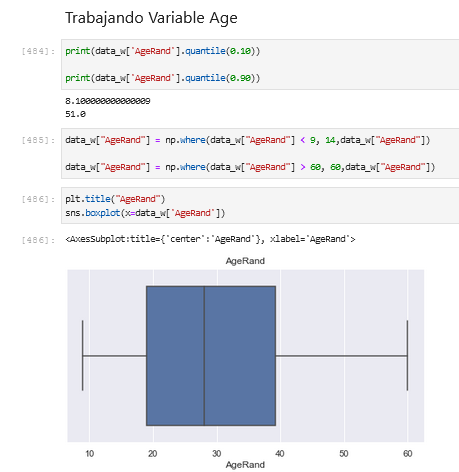

## Realizando OHE para las variables categoricas que lo necesitan:
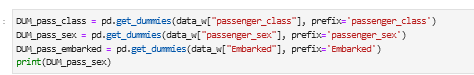


## Feature Scaling:

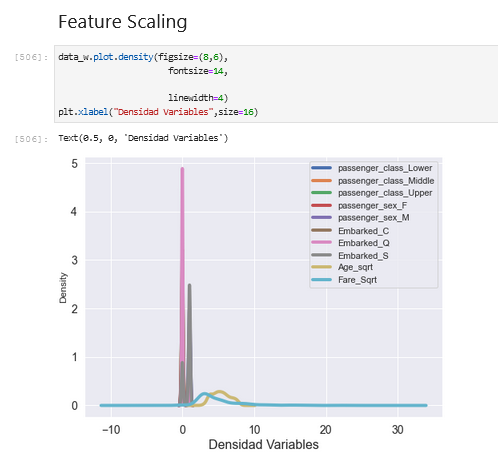

### Resultado del Feature Scaling:
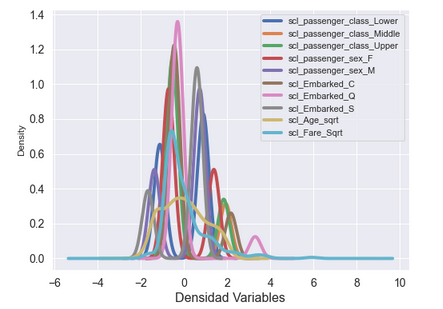

## Análisis de correlación de las variables:
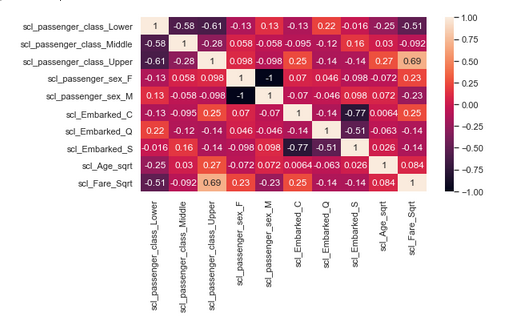

## Conclusiones:
La ejecución de los 4 modelos distintos con la misma data de ingreso y ver que tanto varían los resultados dependiendo el modelo utilizado me pone más en claro el trabajo de un data scientist, quien no se debe quedar con los resultos de un modelo de una sola clase, sino buscar el que mejor sirva para el problema y para la data que se tiene, ya que de esto depende que modelo se puede utilizar. Realizar paso a paso los modelos me permitió entender de mejor manera como se pueden trabajar, los pros y contras de hacerlo y aprender de ello.

De las dificultades más grandes que tengo hasta el momento es trabajar con tensorflow, pero pude superar esto realizando la regresión logistica con el y me permitió entender mejor el concepto de ello.